In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict , Literal
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
import os

In [2]:
### Setting up the LLM model:
model=ChatGroq(model="llama-3.1-8b-instant",
                api_key=os.getenv("API_KEY"))

In [3]:
class Sentimental_analysis_rule(BaseModel):
    Sentiment: Literal['positive','negative','neutral'] = Field(description="The sentiment of the given text")

In [4]:
Structrured_model=model.with_structured_output(Sentimental_analysis_rule)

In [5]:
Review="""The movie was a complete waste of time. The plot was predictable and the characters were one-dimensional. I wouldn't recommend it to anyone."""

In [6]:
### Defining The state:
class Review_State(TypedDict):
    Review: str
    sentiment: Literal['positive','negative','neutral']
    diagnosis: dict
    response: str

In [7]:
def find_sentiment(state:Review_State):
    Prompt=f'Evaluate the sentiment of the following Review:{state["Review"]}'
    result=Structrured_model.invoke(Prompt)
    sentiment=result.Sentiment
    state['sentiment']=sentiment
    return {'sentiment':sentiment}

In [8]:
### Contitional Workflow creation function:
def Sentimental_condition(state: Review_State)-> Literal['positive_response','run_diagnosis']:
    sentiment=state['sentiment']
    if sentiment=='positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

In [10]:
class Diagnosis_Schema(BaseModel):
    issue_type: Literal[
        "Product Defect",
        "Late Delivery",
        "Poor Customer Service",
        "Billing Issue",
        "Wrong Item",
        "Damaged Item",
        "Other"
    ] = Field(description="What is the issue with the product or service")

    tone: Literal[
        "Angry",
        "Frustrated",
        "Sad",
        "Neutral",
        "Disappointed",
        "Confused"
    ] = Field(description="What is the tone of the review")

    urgency_level: Literal[
        "Low",
        "Medium",
        "High",
        "Critical"
    ] = Field(description="How urgent is the issue mentioned in the review")

In [11]:
structured_diagnosis_model=model.with_structured_output(Diagnosis_Schema)

In [12]:
def positive_response(state: Review_State):
    review=state['Review']
    prompt=f"Provide a warm thank you response for the following positive review:{review}"
    response=model.invoke(prompt)
    state['response']=response
    return {'response':response}

In [13]:
def run_diagnosis(state:Review_State):
    review=state['Review']
    prompt=f'Provide a detailed diagnosis for the following negative review:{review} return issue type , tone, urgency level'
    structured_dict=structured_diagnosis_model.invoke(prompt)
    # Convert to dict safely
    result_dict = structured_dict.model_dump()

    # Extract fields
    diagnosis = {
        "issue_type": result_dict.get("issue_type", ""),
        "tone": result_dict.get("tone", ""),
        "urgency_level": result_dict.get("urgency_level", "")
    }
    state['diagnosis']=diagnosis
    return {'diagnosis': diagnosis}

In [14]:
def negative_response(state:Review_State):
    diagnosis=state['diagnosis']
    prompt=f"Based on the following diagnosis:{diagnosis['issue_type']} , customer sounded {diagnosis['tone']} and urgency level {diagnosis['urgency_level']}provide a empathetic response addressing the customer's concerns."
    response=model.invoke(prompt).content
    state['response']=response
    return {'response':response}

In [16]:
### Defining the graph:
graph=StateGraph(Review_State)

### Adding nodes to the graph:
graph.add_node(name="find_sentiment",node=find_sentiment)
graph.add_node(name="positive_response",node=positive_response)
graph.add_node(name="run_diagnosis",node=run_diagnosis)
graph.add_node(name="negative_response",node=negative_response)

### Defying The edge:
graph.add_edge(START,"find_sentiment")
graph.add_edge("positive_response",END)
graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("negative_response",END)

### Adding Conditional edges:
graph.add_conditional_edges("find_sentiment",Sentimental_condition)

###Compiling the graph:
workflow=graph.compile()

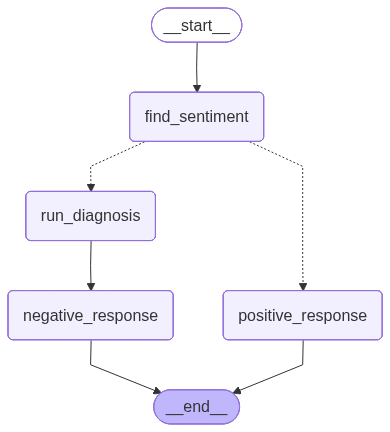

In [17]:
workflow

In [18]:
Initial_state={
    "Review":Review
}
result=workflow.invoke(Initial_state)
print(result)

{'Review': "The movie was a complete waste of time. The plot was predictable and the characters were one-dimensional. I wouldn't recommend it to anyone.", 'sentiment': 'negative', 'diagnosis': {'issue_type': 'Product Defect', 'tone': 'Angry', 'urgency_level': 'Low'}, 'response': 'Here\'s a potential empathetic response:\n\n"Hello [Customer\'s Name], I\'m so sorry to hear that you\'re experiencing issues with your [product name]. I can imagine how frustrating this must be for you, and I appreciate you reaching out to us about it. \n\nI want to assure you that we take all product defects seriously and will do our best to resolve the issue as quickly as possible. I\'m happy to help you with a replacement or repair, whichever you prefer.\n\nBefore we proceed, may I confirm the details of the issue? Can you please provide me with more information about what\'s not working correctly with your [product name]? This will help me to better understand the situation and offer the best possible sol